### Transfer Learning Notebook ###
In this notebook, we attempt to improve our model accuracy using transfer learning with ResNet50.

This notebook is based on the [Transfer Learning for Image Classification using Keras](https://towardsdatascience.com/transfer-learning-for-image-classification-using-keras-c47ccf09c8c8) tutorial.

In [2]:
import matplotlib.pyplot as pl
import keras
import tensorflow as tf
from tensorflow import keras
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Sequential, Model
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
%matplotlib inline

First, we load ResNet50 with include_top=False. We use the same input height and width as our baseline.

In [4]:
HEIGHT = 128
WIDTH = 128
NUM_CLASSES = 41
FC_LAYERS = [1024, 1024]
DROPOUT = 0.5
NUM_EPOCHS = 10
BATCH_SIZE = 32

base_model = ResNet50(weights='imagenet', 
                      include_top=False,
                      input_shape=(HEIGHT,WIDTH,3))

augmented_datagen = ImageDataGenerator(validation_split=0.15, rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
augmented_train_generator = augmented_datagen.flow_from_directory('../data/', subset="training", target_size=(HEIGHT,WIDTH))
augmented_valid_generator = augmented_datagen.flow_from_directory('../data/', subset="validation", target_size=(HEIGHT,WIDTH))

# base_model.summary()

Found 5211 images belonging to 41 classes.
Found 897 images belonging to 41 classes.


We add two fully connected layers with ReLu and a final softmax layer to the top of the model:

In [11]:
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r.')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')

    # plt.figure()
    # plt.plot(epochs, loss, 'r.')
    # plt.plot(epochs, val_loss, 'r-')
    # plt.title('Training and validation loss')
    plt.show()

def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

model = build_finetune_model(base_model, 
                             dropout=DROPOUT, 
                             fc_layers=FC_LAYERS, 
                             num_classes=NUM_CLASSES)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 64, 64, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

In [12]:
adam = Adam(lr=0.00001)
model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])

callbacks_list = [EarlyStopping(patience=2),
                  ModelCheckpoint(filepath='checkpoints/ResNet50.{epoch:02d}.h5', monitor=["acc"], verbose=1, mode='max')]

history = model.fit(augmented_train_generator, 
                    validation_data=augmented_valid_generator, 
                    epochs=10, 
                    steps_per_epoch=5211/32, 
                    validation_steps=897/32,
                    callbacks=callbacks_list)

Epoch 1/10
163/162 [==============================] - 534s 3s/step - loss: 4.8121 - accuracy: 0.0591 - val_loss: 4.0312 - val_accuracy: 0.0870

Epoch 00001: saving model to checkpoints/ResNet50.01.h5
Epoch 2/10
163/162 [==============================] - 520s 3s/step - loss: 3.6491 - accuracy: 0.1443 - val_loss: 4.0313 - val_accuracy: 0.0870

Epoch 00002: saving model to checkpoints/ResNet50.02.h5
Epoch 3/10
163/162 [==============================] - 522s 3s/step - loss: 3.1981 - accuracy: 0.2228 - val_loss: 3.9886 - val_accuracy: 0.0870

Epoch 00003: saving model to checkpoints/ResNet50.03.h5
Epoch 4/10
163/162 [==============================] - 524s 3s/step - loss: 2.8878 - accuracy: 0.2984 - val_loss: 3.6252 - val_accuracy: 0.0870

Epoch 00004: saving model to checkpoints/ResNet50.04.h5
Epoch 5/10
163/162 [==============================] - 522s 3s/step - loss: 2.6156 - accuracy: 0.3621 - val_loss: 4.2300 - val_accuracy: 0.0870

Epoch 00005: saving model to checkpoints/ResNet50.05.h5


This model is overfitting to the training data, strangely, the validation accuracy never increases. Let's try increasing the learning rate.

In [13]:
adam_lr = Adam(lr=3e-4)
model_lr = build_finetune_model(base_model, 
                                dropout=DROPOUT, 
                                fc_layers=FC_LAYERS, 
                                num_classes=NUM_CLASSES)
model_lr.compile(adam_lr, loss='categorical_crossentropy', metrics=['accuracy'])

callbacks_list_lr = [EarlyStopping(patience=2),
                     ModelCheckpoint(filepath='checkpoints/ResNet50LR.{epoch:02d}.h5', monitor=["acc"], verbose=1, mode='max')]

history_lr = model_lr.fit(augmented_train_generator, 
                          validation_data=augmented_valid_generator, 
                          epochs=10, 
                          steps_per_epoch=5211/32, 
                          validation_steps=897/32,
                          callbacks=callbacks_list_lr)

Epoch 1/10
163/162 [==============================] - 531s 3s/step - loss: 3.0670 - accuracy: 0.3268 - val_loss: 4.3479 - val_accuracy: 0.0479

Epoch 00001: saving model to checkpoints/ResNet50LR.01.h5
Epoch 2/10
163/162 [==============================] - 515s 3s/step - loss: 1.7991 - accuracy: 0.5594 - val_loss: 1.7557 - val_accuracy: 0.0479

Epoch 00002: saving model to checkpoints/ResNet50LR.02.h5
Epoch 3/10
163/162 [==============================] - 514s 3s/step - loss: 1.4224 - accuracy: 0.6500 - val_loss: 4.1542 - val_accuracy: 0.0479

Epoch 00003: saving model to checkpoints/ResNet50LR.03.h5
Epoch 4/10
163/162 [==============================] - 512s 3s/step - loss: 1.1784 - accuracy: 0.7031 - val_loss: 4.0409 - val_accuracy: 0.0479

Epoch 00004: saving model to checkpoints/ResNet50LR.04.h5


The validation accuracy went down, but still stays the same through all epochs. What is happening here?

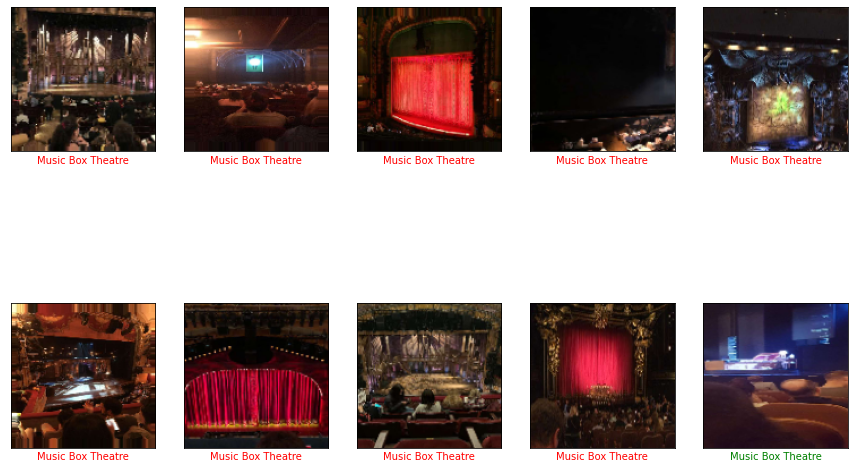

In [20]:
import plotting_util
import numpy as np

valid_examples = augmented_valid_generator.next()

classifications = []

for im in valid_examples[0]:
    im_reshaped = tf.reshape(im, [-1, 128, 128, 3])
    one_hot = np.zeros((42))
    one_hot[np.argmax(model_lr.predict(np.expand_dims(im, axis=0)))] = 1
    classifications.append(one_hot)

plotting_util.plot_classification_examples(classifications,valid_examples[1],valid_examples[0])

Visualizing the predictions, it seems to be predicting Music Box Theatre for every input. Music Box Theatre examples probably make up 4.8% of the dataset. What about the previous model?

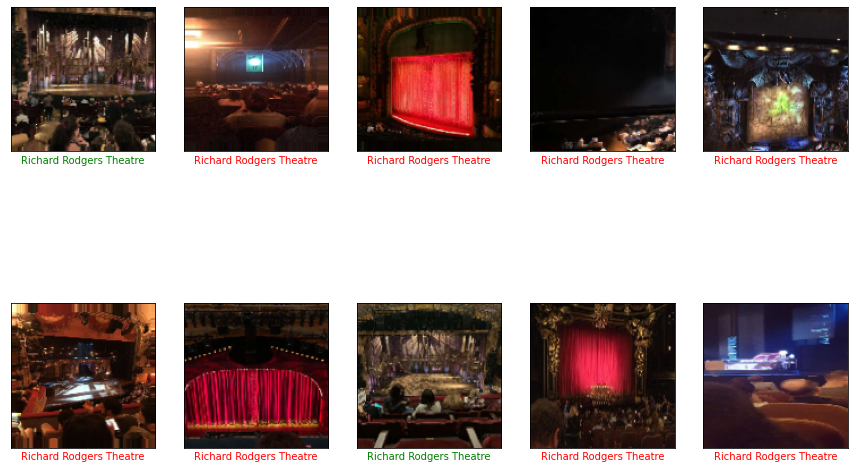

In [21]:
classifications = []

for im in valid_examples[0]:
    im_reshaped = tf.reshape(im, [-1, 128, 128, 3])
    one_hot = np.zeros((42))
    one_hot[np.argmax(model.predict(np.expand_dims(im, axis=0)))] = 1
    classifications.append(one_hot)

plotting_util.plot_classification_examples(classifications,valid_examples[1],valid_examples[0])

Same problem! The Richard Rodgers Theatre makes up 8.7% of the dataset.